In [1]:
%load_ext autoreload
%autoreload 2

import numpy
import matplotlib as mpl
import matplotlib.pyplot as plt

from utils import *

mpl.rcParams['mathtext.default'] = 'regular'
cmap = mpl.colormaps['plasma']

In [2]:
sheet_names = ['V1_Exc_L4', 'V1_Inh_L4', 'V1_Exc_L2/3', 'V1_Inh_L2/3']
sheet_names_formatted = {
    'V1_Exc_L4': "Layer 4 Exc.",
    'V1_Inh_L4': "Layer 4 Inh.",
    'V1_Exc_L2/3': "Layer 2/3 Exc.",
    'V1_Inh_L2/3': "Layer 2/3 Inh.",
}

In [3]:
class CellRate():

    def __init__(self, prefered_orientation=None):
        self.prefered_orientation = prefered_orientation
        self.gratings_rates = []
        self.gratings_orientations = []
        self.gratings_radius = []
        self.spont_rate = []

    @property
    def grating_orientation_relative(self):
        _rel_orient = []
        for go in self.gratings_orientations:
            _diff = go - self.prefered_orientation
            if _diff < - (numpy.pi / 2):
                _diff += numpy.pi
            if _diff > numpy.pi / 2:
                _diff -= numpy.pi
            _rel_orient.append(_diff)
        return _rel_orient

    def get_mean_rate_for_radius(self, target_radius):
        if not cell.spont_rate:
            return numpy.nan

        _rates = []
        for radius, rate in zip(self.gratings_radius, self.gratings_rates):
            if numpy.isclose(radius, target_radius, atol=0.05):
                _rates.append(rate)# / self.spont_rate)

        return numpy.nanmean(_rates)

# Spontaneous

In [4]:
run_id = "20250505-084337"
for sheet_name in sheet_names:
    datastore_to_pickle(run_id, sheet_name)
data_store = get_data_stores(run_id)[0]

Reading folder ./20250505-084337[param_split_1split.defaults]CombinationParamSearch{21}/SelfSustainedPushPull_ParameterSearch_____pynn_seed:1_base_weight:3.476e-05_base_weight:0.00021501_base_weight:0.00024486_base_weight:0.00021577_base_
Pickling 20250505-084337, sheet V1_Exc_L4
1 / 41 , 2 / 41 , 3 / 41 , 4 / 41 , 5 / 41 , 6 / 41 , 7 / 41 , 8 / 41 , 9 / 41 , 10 / 41 , 11 / 41 , 12 / 41 , 13 / 41 , 14 / 41 , 15 / 41 , 16 / 41 , 17 / 41 , 18 / 41 , 19 / 41 , 20 / 41 , 21 / 41 , 22 / 41 , 23 / 41 , 24 / 41 , 25 / 41 , 26 / 41 , 27 / 41 , 28 / 41 , 29 / 41 , 30 / 41 , 31 / 41 , 32 / 41 , 33 / 41 , 34 / 41 , 35 / 41 , 36 / 41 , 37 / 41 , 38 / 41 , 39 / 41 , 40 / 41 , 
Took 214.57382678985596s for 41 segments
Reading folder ./20250505-084337[param_split_1split.defaults]CombinationParamSearch{21}/SelfSustainedPushPull_ParameterSearch_____pynn_seed:1_base_weight:3.476e-05_base_weight:0.00021501_base_weight:0.00024486_base_weight:0.00021577_base_
Pickling 20250505-084337, sheet V1_Inh_L4
1 / 4

In [5]:
# Get the spont activity
data_per_sheet = {}
for sheet_name in sheet_names:
    data = read_pickled_datastore(run_id, sheet_name)
    data_per_sheet[sheet_name] = next(seg for seg in data if 'orientation' not in seg.annotation)

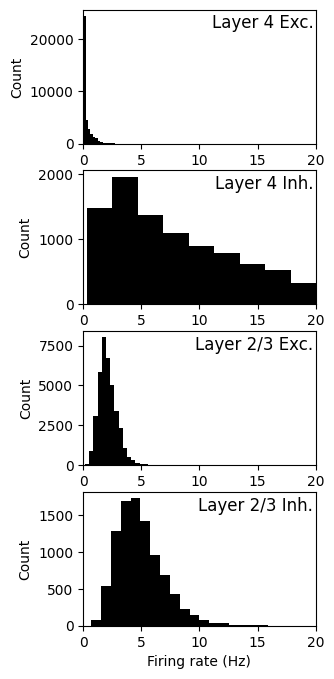

In [6]:
# SANITY TEST:
tolerance = 0.1 # rad
fig, axs = plt.subplots(4, figsize=(3, 8))
for idx_ax, sheet_name in enumerate(sheet_names):
    spont_seg = data_per_sheet[sheet_name]
    axs[idx_ax].hist([1000. * len(st) / spont_seg.duration for st in spont_seg.spiketrains], color="black", bins=20)
    axs[idx_ax].set_ylabel("Count")
    axs[idx_ax].set_xlim(0, 20)
    axs[idx_ax].set_title(sheet_names_formatted[sheet_name], x=0.99, y=0.80, ha='right') 
axs[-1].set_xlabel("Firing rate (Hz)")

plt.savefig(f"./figures/hist_firing_rate_{run_id}.png", dpi=100, bbox_inches="tight", transparent=True)
plt.show()

In [7]:
# Test sampling synchrony
"""import random

for sheet_name in sheet_names:

    fig, ax = plt.subplots(1, figsize=(4, 2.5))
    print(sheet_name)
    seg = data_per_sheet[sheet_name]
    x_pos = data_store.get_neuron_positions()[sheet_name][0]
    y_pos = data_store.get_neuron_positions()[sheet_name][1]

    means = []
    stds = []
    for n_cells in [10, 20, 50, 100, 200, 500, 1000, 2000, 3000]:
        spiketrains = [st for idx, st in enumerate(seg.spiketrains) if abs(x_pos[idx]) < 1. and abs(y_pos[idx]) < 1.]
        random.shuffle(spiketrains)
        spiketrains = spiketrains[:n_cells]
        isis = [numpy.diff(st) for st in spiketrains]
        idxs = numpy.array([len(isi) for isi in isis]) > 5
        num_bins = int(seg.duration / 10.)
        r = (float(round(seg.t_start, 5)), float(round(seg.t_stop, 5)))
        psths = [numpy.histogram(x, bins=num_bins, range=r)[0] for x in spiketrains]
        corrs = numpy.nan_to_num(numpy.corrcoef(numpy.squeeze(psths)))
        ccs = corrs[idxs, :][:, idxs][numpy.triu_indices(sum(idxs == True), 1)]
        cc_mean = float(numpy.mean(ccs))
        cc_std = float(numpy.std(ccs))
        means.append(cc_mean)
        stds.append(cc_std)
    
    ax.scatter([10, 20, 50, 100, 200, 500, 1000, 2000, 3000], means, label="1mm square")

    means = []
    stds = []
    for n_cells in [10, 20, 50, 100, 200, 500, 1000, 2000, 3000]:
        spiketrains = [st for idx, st in enumerate(seg.spiketrains) if abs(x_pos[idx]) < 1.5 and abs(y_pos[idx]) < 1.5]
        random.shuffle(spiketrains)
        spiketrains = spiketrains[:n_cells]
        isis = [numpy.diff(st) for st in spiketrains]
        idxs = numpy.array([len(isi) for isi in isis]) > 5
        num_bins = int(seg.duration / 10.)
        r = (float(round(seg.t_start, 5)), float(round(seg.t_stop, 5)))
        psths = [numpy.histogram(x, bins=num_bins, range=r)[0] for x in spiketrains]
        corrs = numpy.nan_to_num(numpy.corrcoef(numpy.squeeze(psths)))
        ccs = corrs[idxs, :][:, idxs][numpy.triu_indices(sum(idxs == True), 1)]
        cc_mean = float(numpy.mean(ccs))
        cc_std = float(numpy.std(ccs))
        means.append(cc_mean)
        stds.append(cc_std)
    
    ax.scatter([10, 20, 50, 100, 200, 500, 1000, 2000, 3000], means, label="1.5mm square")

    means = []
    stds = []
    for n_cells in [10, 20, 50, 100, 200, 500, 1000, 2000, 3000]:
        spiketrains = seg.spiketrains[:]
        random.shuffle(spiketrains)
        spiketrains = spiketrains[:n_cells]
        isis = [numpy.diff(st) for st in spiketrains]
        idxs = numpy.array([len(isi) for isi in isis]) > 5
        num_bins = int(seg.duration / 10.)
        r = (float(round(seg.t_start, 5)), float(round(seg.t_stop, 5)))
        psths = [numpy.histogram(x, bins=num_bins, range=r)[0] for x in spiketrains]
        corrs = numpy.nan_to_num(numpy.corrcoef(numpy.squeeze(psths)))
        ccs = corrs[idxs, :][:, idxs][numpy.triu_indices(sum(idxs == True), 1)]
        cc_mean = float(numpy.mean(ccs))
        cc_std = float(numpy.std(ccs))
        means.append(cc_mean)
        stds.append(cc_std)
    
    ax.scatter([10, 20, 50, 100, 200, 500, 1000, 2000, 3000], means, label="RCAll")
    
    #ax.set_xscale('log')
    ax.set_xlabel('Sampling size')
    ax.set_ylabel('Synchrony')
    ax.set_xlim(400, 3200)

    ax.legend()
    plt.show()
    plt.clf()"""

'import random\n\nfor sheet_name in sheet_names:\n\n    fig, ax = plt.subplots(1, figsize=(4, 2.5))\n    print(sheet_name)\n    seg = data_per_sheet[sheet_name]\n    x_pos = data_store.get_neuron_positions()[sheet_name][0]\n    y_pos = data_store.get_neuron_positions()[sheet_name][1]\n\n    means = []\n    stds = []\n    for n_cells in [10, 20, 50, 100, 200, 500, 1000, 2000, 3000]:\n        spiketrains = [st for idx, st in enumerate(seg.spiketrains) if abs(x_pos[idx]) < 1. and abs(y_pos[idx]) < 1.]\n        random.shuffle(spiketrains)\n        spiketrains = spiketrains[:n_cells]\n        isis = [numpy.diff(st) for st in spiketrains]\n        idxs = numpy.array([len(isi) for isi in isis]) > 5\n        num_bins = int(seg.duration / 10.)\n        r = (float(round(seg.t_start, 5)), float(round(seg.t_stop, 5)))\n        psths = [numpy.histogram(x, bins=num_bins, range=r)[0] for x in spiketrains]\n        corrs = numpy.nan_to_num(numpy.corrcoef(numpy.squeeze(psths)))\n        ccs = corrs[idx

In [8]:
# Test sampling synchrony
"""import random
from scipy.spatial.distance import cdist

fig, ax = plt.subplots(1, figsize=(4, 2.5))

seg = data_per_sheet[sheet_names[2]]
means = []
stds = []

for probe_space in [30, 50, 100, 200]:

    probe_pos = [[i, j] for i in range(-1500, 1500, probe_space) for j in range(-1500, 1500, probe_space)]
    x_pos = data_store.get_neuron_positions()[sheet_names[2]][0]
    y_pos = data_store.get_neuron_positions()[sheet_names[2]][1]
    distances = cdist(probe_pos, data_store.get_neuron_positions()[sheet_names[2]][:2].T)
    
    spiketrains = []
    for idx_probe in range(len(probe_pos)):
        spiketrains.append(seg.spiketrains[numpy.argmin(distances[idx_probe])])
    
    isis = [numpy.diff(st) for st in spiketrains]
    idxs = numpy.array([len(isi) for isi in isis]) > 5
    num_bins = int(seg.duration / 10.)
    r = (float(round(seg.t_start, 5)), float(round(seg.t_stop, 5)))
    psths = [numpy.histogram(x, bins=num_bins, range=r)[0] for x in spiketrains]
    corrs = numpy.nan_to_num(numpy.corrcoef(numpy.squeeze(psths)))
    ccs = corrs[idxs, :][:, idxs][numpy.triu_indices(sum(idxs == True), 1)]
    cc_mean = float(numpy.mean(ccs))
    cc_std = float(numpy.std(ccs))
    means.append(cc_mean)
    stds.append(cc_std)
    
    ax.scatter(probe_space, cc_mean, color="C0")


for probe_space in [50, 100, 200]:

    probe_pos = [[i, j] for i in range(-2000, 2000, probe_space) for j in range(-2000, 2000, probe_space)]
    x_pos = data_store.get_neuron_positions()[sheet_names[2]][0]
    y_pos = data_store.get_neuron_positions()[sheet_names[2]][1]
    distances = cdist(probe_pos, data_store.get_neuron_positions()[sheet_names[2]][:2].T)
    
    spiketrains = []
    for idx_probe in range(len(probe_pos)):
        spiketrains.append(seg.spiketrains[numpy.argmin(distances[idx_probe])])
    
    isis = [numpy.diff(st) for st in spiketrains]
    idxs = numpy.array([len(isi) for isi in isis]) > 5
    num_bins = int(seg.duration / 10.)
    r = (float(round(seg.t_start, 5)), float(round(seg.t_stop, 5)))
    psths = [numpy.histogram(x, bins=num_bins, range=r)[0] for x in spiketrains]
    corrs = numpy.nan_to_num(numpy.corrcoef(numpy.squeeze(psths)))
    ccs = corrs[idxs, :][:, idxs][numpy.triu_indices(sum(idxs == True), 1)]
    cc_mean = float(numpy.mean(ccs))
    cc_std = float(numpy.std(ccs))
    means.append(cc_mean)
    stds.append(cc_std)
    
    ax.scatter(probe_space, cc_mean, color="C1")

ax.set_xlabel('Probe spacing (um)')
ax.set_ylabel('Synchrony')
plt.show()"""

'import random\nfrom scipy.spatial.distance import cdist\n\nfig, ax = plt.subplots(1, figsize=(4, 2.5))\n\nseg = data_per_sheet[sheet_names[2]]\nmeans = []\nstds = []\n\nfor probe_space in [30, 50, 100, 200]:\n\n    probe_pos = [[i, j] for i in range(-1500, 1500, probe_space) for j in range(-1500, 1500, probe_space)]\n    x_pos = data_store.get_neuron_positions()[sheet_names[2]][0]\n    y_pos = data_store.get_neuron_positions()[sheet_names[2]][1]\n    distances = cdist(probe_pos, data_store.get_neuron_positions()[sheet_names[2]][:2].T)\n    \n    spiketrains = []\n    for idx_probe in range(len(probe_pos)):\n        spiketrains.append(seg.spiketrains[numpy.argmin(distances[idx_probe])])\n    \n    isis = [numpy.diff(st) for st in spiketrains]\n    idxs = numpy.array([len(isi) for isi in isis]) > 5\n    num_bins = int(seg.duration / 10.)\n    r = (float(round(seg.t_start, 5)), float(round(seg.t_stop, 5)))\n    psths = [numpy.histogram(x, bins=num_bins, range=r)[0] for x in spiketrains]\

In [9]:
# Test if same cell picked
"""from collections import Counter
from scipy.spatial.distance import cdist

cell_pos = data_store.get_neuron_positions()[sheet_names[2]][:2].T * 1000.
probe_pos = numpy.array([[i, j] for i in range(-1500, 1500, 20) for j in range(-1500, 1500, 20)])

plt.scatter(cell_pos[:, 0], cell_pos[:, 1])
plt.scatter(probe_pos[:, 0], probe_pos[:, 1])
plt.show()

distances = cdist(probe_pos, cell_pos)
selected_index = [numpy.argmin(distances[idx_probe]) for idx_probe in range(len(probe_pos))]
print(len(selected_index), len(list(set(selected_index))))"""

'from collections import Counter\nfrom scipy.spatial.distance import cdist\n\ncell_pos = data_store.get_neuron_positions()[sheet_names[2]][:2].T * 1000.\nprobe_pos = numpy.array([[i, j] for i in range(-1500, 1500, 20) for j in range(-1500, 1500, 20)])\n\nplt.scatter(cell_pos[:, 0], cell_pos[:, 1])\nplt.scatter(probe_pos[:, 0], probe_pos[:, 1])\nplt.show()\n\ndistances = cdist(probe_pos, cell_pos)\nselected_index = [numpy.argmin(distances[idx_probe]) for idx_probe in range(len(probe_pos))]\nprint(len(selected_index), len(list(set(selected_index))))'

/home/tanguy.damart/virt_env/mozaik/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/tanguy.damart/virt_env/mozaik/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/tanguy.damart/virt_env/mozaik/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/tanguy.damart/virt_env/mozaik/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tanguy.damart/virt_env/mozaik/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/tanguy.damart/virt_env/mozaik

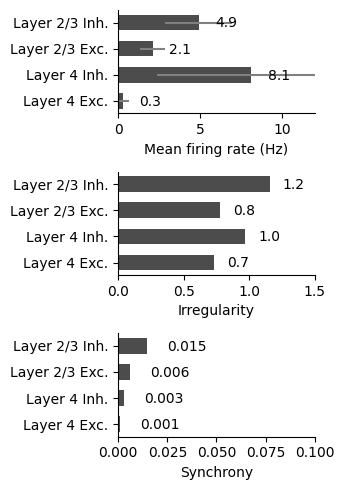

In [10]:
fig, axs = plt.subplots(3, figsize=(3.5, 5))

# Plot the spont activity rate/CC/CV with error bar
for ypos, (sheet_name, seg) in enumerate(data_per_sheet.items()):
    mean_rate = float(seg.mean_rate)
    std_rate = float(numpy.std([1000. * len(s) / seg.duration for s in seg.spiketrains]))
    axs[0].barh(ypos, mean_rate, height=0.6, color="black", alpha=0.7)
    axs[0].errorbar(mean_rate, ypos, xerr=float(std_rate), color="gray")
    axs[0].text(mean_rate + 1, ypos - 0.19, f"{mean_rate:.1f}")

axs[0].set_xlim(0, 12)
axs[0].set_xlabel("Mean firing rate (Hz)")

# Plot the Irregularity (CV)
for ypos, (sheet_name, seg) in enumerate(data_per_sheet.items()):
    isis = [numpy.diff(st) for st in seg.spiketrains]
    idxs = numpy.array([len(isi) for isi in isis]) > 5
    cvs = numpy.array([numpy.std(isi) / numpy.mean(isi) for isi in isis])[idxs]
    cv_mean = float(numpy.mean(cvs))
    cv_std = float(numpy.std(cvs))
    axs[1].barh(ypos, cv_mean, height=0.6, color="black", alpha=0.7)
    axs[1].errorbar(mean_rate, ypos, xerr=cv_std, color="gray")
    axs[1].text(cv_mean + 0.1, ypos - 0.19, f"{cv_mean:.1f}")

axs[1].set_xlim(0, 1.5)
axs[1].set_xlabel("Irregularity")

# Plot the Synchrony (CV)
for ypos, (sheet_name, seg) in enumerate(data_per_sheet.items()):
    x_pos = data_store.get_neuron_positions()[sheet_name][0]
    y_pos = data_store.get_neuron_positions()[sheet_name][1]
    spiketrains = seg.spiketrains
    spiketrains = [st for idx, st in enumerate(spiketrains) if abs(x_pos[idx]) < 1. and abs(y_pos[idx]) < 1.]
    spiketrains = spiketrains[:2000]
    isis = [numpy.diff(st) for st in spiketrains]
    idxs = numpy.array([len(isi) for isi in isis]) > 5
    num_bins = int(seg.duration / 10.)
    r = (float(round(seg.t_start, 5)), float(round(seg.t_stop, 5)))
    psths = [numpy.histogram(x, bins=num_bins, range=r)[0] for x in spiketrains]
    corrs = numpy.nan_to_num(numpy.corrcoef(numpy.squeeze(psths)))
    ccs = corrs[idxs, :][:, idxs][numpy.triu_indices(sum(idxs == True), 1)]
    cc_mean = float(numpy.mean(ccs))
    cc_std = float(numpy.std(ccs))
    axs[2].barh(ypos, cc_mean, height=0.6, color="black", alpha=0.7)
    axs[2].errorbar(mean_rate, ypos, xerr=cc_std, color="gray")
    axs[2].text(cc_mean + 0.01, ypos - 0.19, f"{cc_mean:.3f}")

axs[2].set_xlim(0, 0.1)
axs[2].set_xlabel("Synchrony")

for ax in axs:
    ax.set_yticks(list(range(len(data_per_sheet))))
    ax.set_yticklabels([sheet_names_formatted[n] for n in data_per_sheet.keys()])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()

plt.savefig(f"./figures/spontaneous_activity_{run_id}.png", dpi=100, bbox_inches="tight", transparent=True)
plt.show()

# Orientation tuning

In [11]:
run_id = "20250505-084337"
for sheet_name in sheet_names:
    datastore_to_pickle(run_id, sheet_name)

Did not pickle 20250505-084337 because it has already been pickled
Did not pickle 20250505-084337 because it has already been pickled
Did not pickle 20250505-084337 because it has already been pickled
Did not pickle 20250505-084337 because it has already been pickled


In [12]:
# Get the OT activity
data_per_sheet = {}
data_spont_per_sheet = {}
data_store = get_data_stores(run_id)[0]
for sheet_name in sheet_names:
    data = read_pickled_datastore(run_id, sheet_name)
    data_per_sheet[sheet_name] = [seg for seg in data if 'orientation' in seg.annotation]
    data_spont_per_sheet[sheet_name] = next(seg for seg in data if 'orientation' not in seg.annotation)

Reading folder ./20250505-084337[param_split_1split.defaults]CombinationParamSearch{21}/SelfSustainedPushPull_ParameterSearch_____pynn_seed:1_base_weight:3.476e-05_base_weight:0.00021501_base_weight:0.00024486_base_weight:0.00021577_base_


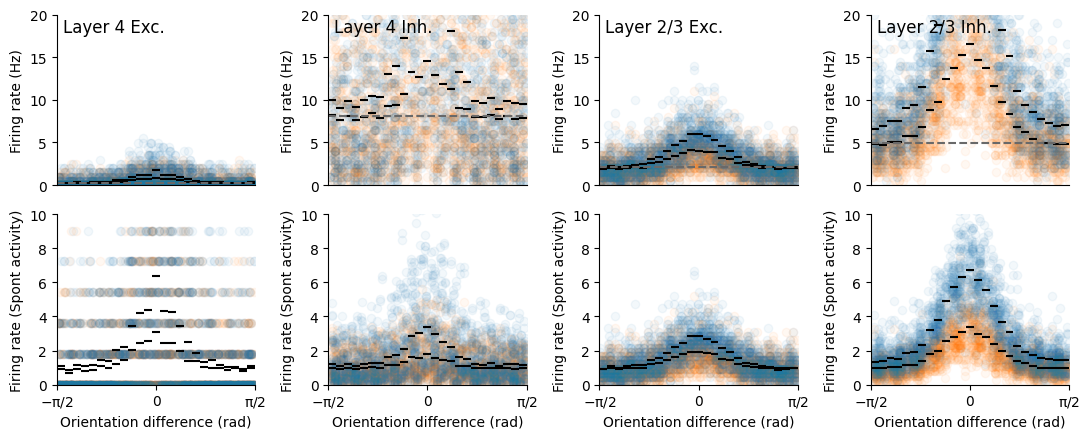

In [13]:
from scipy import stats

fig, axs = plt.subplots(2, 4, figsize=(11, 4.5))

for idx_plot, sheet_name in enumerate(sheet_names):

    orientations_cells = get_orientation_preference(data_store, sheet_name)

    for contrast in [10, 100]:

        cells = [CellRate(oc) for oc in orientations_cells]

        # Get the gratings fire rate
        for seg in data_per_sheet[sheet_name]:
            if seg.annotation["contrast"] == contrast:
                for idx, st in enumerate(seg.spiketrains):
                    cells[idx].gratings_rates.append(1000. * len(st) / seg.duration)
                    cells[idx].gratings_orientations.append(seg.annotation["orientation"])

        # Binning
        x = []
        y = []
        for cell in cells[:400]:
            x += cell.grating_orientation_relative
            y += cell.gratings_rates
        bin_means, bin_edges, binnumber = stats.binned_statistic(x, y, statistic='mean', bins=25, range=(-numpy.pi / 2, numpy.pi / 2))
        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = bin_edges[1:] - bin_width/2

        color = "C0" if contrast == 100 else "C1"
        for cell in cells[:100]:
            axs[0][idx_plot].scatter(cell.grating_orientation_relative, cell.gratings_rates, color=color, alpha=0.05)
            axs[1][idx_plot].scatter(cell.grating_orientation_relative, cell.gratings_rates / data_spont_per_sheet[sheet_name].mean_rate, color=color, alpha=0.05)

        axs[0][idx_plot].hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='black', lw=1.5)
        axs[1][idx_plot].hlines(bin_means / data_spont_per_sheet[sheet_name].mean_rate, bin_edges[:-1], bin_edges[1:], colors='black', lw=1.5)
        axs[0][idx_plot].set_title(sheet_names_formatted[sheet_name], x=0.03, y=0.85, ha='left') 

    # Spontaneous rate
    axs[0][idx_plot].axhline(data_spont_per_sheet[sheet_name].mean_rate, color='dimgray', lw=1.5, ls='--')

for ax in axs[0]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(-numpy.pi / 2, numpy.pi / 2)
    ax.set_ylim(0, 20)
    ax.set_ylabel("Firing rate (Hz)")
    ax.set_xticks([])
    ax.set_xticklabels([])

for ax in axs[1]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(-numpy.pi / 2, numpy.pi / 2)
    ax.set_ylim(0, 10)
    ax.set_ylabel("Firing rate (Spont activity)")
    ax.set_xlabel("Orientation difference (rad)")
    ax.set_xticks([-numpy.pi / 2, 0, numpy.pi / 2])
    ax.set_xticklabels([r'$-\pi /2$', '0', r'$\pi /2$'])

plt.tight_layout()

plt.savefig(f"./figures/orientation_tuning_{run_id}.png", dpi=100, bbox_inches="tight", transparent=True)
plt.show()

# Size tuning

In [14]:
run_id = "20250505-084359"
tolerance = 0.1  # rad

for sheet_name in ['V1_Exc_L4', 'V1_Inh_L4', 'V1_Exc_L2/3', 'V1_Inh_L2/3']:
    datastore_to_pickle(run_id, sheet_name)

Reading folder ./20250505-084359[param_split_1split.defaults]CombinationParamSearch{21}/SelfSustainedPushPull_ParameterSearch_____pynn_seed:1_base_weight:3.476e-05_base_weight:0.00021501_base_weight:0.00024486_base_weight:0.00021577_base_
Pickling 20250505-084359, sheet V1_Exc_L4
0 / 65 , 1 / 65 , 2 / 65 , 3 / 65 , 4 / 65 , 5 / 65 , 6 / 65 , 7 / 65 , 8 / 65 , 9 / 65 , 10 / 65 , 11 / 65 , 12 / 65 , 13 / 65 , 14 / 65 , 15 / 65 , 16 / 65 , 17 / 65 , 18 / 65 , 19 / 65 , 20 / 65 , 21 / 65 , 22 / 65 , 23 / 65 , 24 / 65 , 25 / 65 , 26 / 65 , 27 / 65 , 28 / 65 , 29 / 65 , 30 / 65 , 31 / 65 , 32 / 65 , 33 / 65 , 34 / 65 , 35 / 65 , 36 / 65 , 37 / 65 , 38 / 65 , 39 / 65 , 40 / 65 , 41 / 65 , 42 / 65 , 43 / 65 , 44 / 65 , 45 / 65 , 46 / 65 , 47 / 65 , 48 / 65 , 49 / 65 , 50 / 65 , 51 / 65 , 52 / 65 , 53 / 65 , 54 / 65 , 55 / 65 , 56 / 65 , 57 / 65 , 58 / 65 , 59 / 65 , 60 / 65 , 61 / 65 , 62 / 65 , 63 / 65 , 64 / 65 , 
Took 351.1039147377014s for 65 segments
Reading folder ./20250505-084359[param

In [15]:
# Get the ST activity
data_per_sheet = {}
data_spont_per_sheet = {}
data_store = get_data_stores(run_id)[0]
for sheet_name in sheet_names:
    data = read_pickled_datastore(run_id, sheet_name)
    data_per_sheet[sheet_name] = [seg for seg in data if 'orientation' in seg.annotation]
    data_spont_per_sheet[sheet_name] = next(seg for seg in data if 'orientation' not in seg.annotation)

Reading folder ./20250505-084359[param_split_1split.defaults]CombinationParamSearch{21}/SelfSustainedPushPull_ParameterSearch_____pynn_seed:1_base_weight:3.476e-05_base_weight:0.00021501_base_weight:0.00024486_base_weight:0.00021577_base_


In [16]:
# Size tuning based on fitting with sum of gaussians
from scipy.optimize import differential_evolution
from scipy.special import erf


def sum_of_gaussian(p, x):
        return (p[0] * erf(x / p[1])**2
                - p[2] * erf(x / (p[1] + p[3]))**2
                + p[4] * erf(x / (p[1] + p[3] + p[5]))**2
                + p[6])


def error_function_evo(p, *args):
    x, y = args
    return numpy.linalg.norm(sum_of_gaussian(p, x) - y)


sheet_name = sheet_names[2]

spont_segment = data_spont_per_sheet[sheet_name]
grating_segments = data_per_sheet[sheet_name]

gratings_orientations = set([seg.annotation['orientation'] for seg in grating_segments if 'orientation' in seg.annotation])
orientations_cells = get_orientation_preference(data_store, sheet_name)

cells = [CellRate(oc) for oc in orientations_cells]
for idx, st in enumerate(spont_segment.spiketrains):
    cells[idx].spont_rate = 1000. * len(st) / spont_segment.duration

# Get the gratings fire rate
for orientation in gratings_orientations:
    for seg in grating_segments:
        if 'contrast' in seg.annotation and seg.annotation["contrast"] == contrast:
            for idx, st in enumerate(seg.spiketrains):
                if numpy.isclose(cells[idx].prefered_orientation, seg.annotation["orientation"], atol=tolerance):
                    cells[idx].gratings_rates.append(1000. * len(st) / seg.duration)
                    cells[idx].gratings_orientations.append(seg.annotation["orientation"])
                    cells[idx].gratings_radius.append(seg.annotation["radius"])

cells = [c for c in cells if len(c.gratings_rates)]
radiuses = sorted(list(set([seg.annotation["radius"] for seg in grating_segments if 'radius' in seg.annotation])))

In [17]:
crf_sizes = []
supp_sizes = []
sis = []
max_responses = []
csis = []
errs = []

for idx_cell, cell in enumerate(cells):

    if idx_cell % 100 == 0:
        print(idx_cell, len(cells))

    values = [cell.get_mean_rate_for_radius(radius) for radius in radiuses]
    rads = list(radiuses)

    rads, values = zip(*sorted(zip(rads,values)))
    rads = numpy.array(rads)
    values = numpy.array(values)

    res = differential_evolution(
        error_function_evo,
        bounds=[(0, 60), (0, 20), (0, 60), (0, 15), (0, 15), (0, 25), (0, 5)],
        args=(rads, values),
        strategy='rand2bin',
        maxiter=10000,
        popsize=30,
        tol=0.1,
        mutation=(0.5, 1.5),
        recombination=0.95,
        workers=1,
    )
    #print(f"Residual loss evo: {error_function_evo(res.x, *(rads, values))}")
    errs.append(error_function_evo(res.x, *(rads, values)))

    X_fit = numpy.linspace(0, 5, 100)
    values_fit = sum_of_gaussian(res.x, X_fit)

    if False:
        fig, ax = plt.subplots(1, figsize=(3, 2))
        print(errs[-1])
        ax.scatter(rads, values, color="black")
        ax.plot(X_fit, values_fit)
        plt.show()

    max_response = numpy.max(values_fit)
    crf_index  = numpy.argmax(values_fit)
    crf_size = X_fit[crf_index]

    if crf_index < len(values_fit)-1:
        supp_index = crf_index+numpy.argmin(values_fit[crf_index+1:])+1
    else:
        supp_index = len(values_fit)-1
    supp_size = X_fit[supp_index]

    if supp_index < len(values_fit)-1:
        cs_index = supp_index+numpy.argmax(values_fit[supp_index+1:])+1
    else:
        cs_index = len(values_fit)-1

    if values_fit[crf_index] != 0:
        si = (values_fit[crf_index]-values_fit[supp_index])/values_fit[crf_index]
    else:
        si = 0

    if values_fit[cs_index] != 0:
        csi = (values_fit[cs_index]-values_fit[supp_index])/values_fit[crf_index]
    else:
        csi = 0

    crf_sizes.append(crf_size)
    supp_sizes.append(supp_size)
    sis.append(si)
    max_responses.append(max_response)
    csis.append(csi)

0 1357


/tmp/ipykernel_1213434/3860347402.py:7: RuntimeWarning: divide by zero encountered in divide
  return (p[0] * erf(x / p[1])**2
/tmp/ipykernel_1213434/3860347402.py:7: RuntimeWarning: invalid value encountered in divide
  return (p[0] * erf(x / p[1])**2
/tmp/ipykernel_1213434/3860347402.py:8: RuntimeWarning: divide by zero encountered in divide
  - p[2] * erf(x / (p[1] + p[3]))**2
/tmp/ipykernel_1213434/3860347402.py:8: RuntimeWarning: invalid value encountered in divide
  - p[2] * erf(x / (p[1] + p[3]))**2
/tmp/ipykernel_1213434/3860347402.py:9: RuntimeWarning: divide by zero encountered in divide
  + p[4] * erf(x / (p[1] + p[3] + p[5]))**2
/tmp/ipykernel_1213434/3860347402.py:9: RuntimeWarning: invalid value encountered in divide
  + p[4] * erf(x / (p[1] + p[3] + p[5]))**2


100 1357
200 1357
300 1357
400 1357
500 1357
600 1357
700 1357
800 1357
900 1357
1000 1357
1100 1357
1200 1357
1300 1357


In [18]:
# Filter the cell:
sis_filtered = [si for si, er in zip(sis, errs) if er < 10]
csis_filtered = [csi for csi, er in zip(csis, errs) if er < 10]

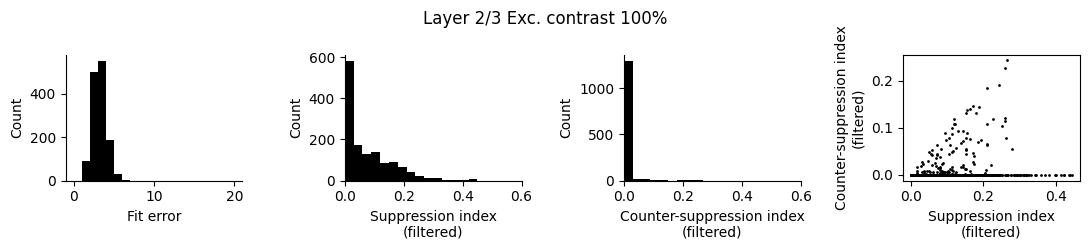

In [19]:
fig, axs = plt.subplots(1, 4, figsize=(11, 2.5))

axs[0].hist(errs, color="black", bins=20, range=(0, 20))
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].set_xlabel("Fit error")
axs[0].set_ylabel("Count")

axs[1].hist(sis_filtered, color="black", range=(0., 0.6), bins=20)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].set_xlabel("Suppression index\n(filtered)")
axs[1].set_ylabel("Count")
axs[1].set_xlim(0, 0.6)

axs[2].hist(csis_filtered, color="black", range=(0., 0.6), bins=20)
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[2].set_xlabel("Counter-suppression index\n(filtered)")
axs[2].set_ylabel("Count")
axs[2].set_xlim(0, 0.6)

axs[3].scatter(sis_filtered, csis_filtered, color="black", s=1)
axs[3].set_xlabel("Suppression index\n(filtered)")
axs[3].set_ylabel("Counter-suppression index\n(filtered)")

fig.suptitle(f"{sheet_names_formatted[sheet_name]} contrast 100%")

plt.tight_layout()

plt.savefig(f"./figures/size_tuning_{run_id}.png", dpi=100, bbox_inches="tight", transparent=True)
plt.show()

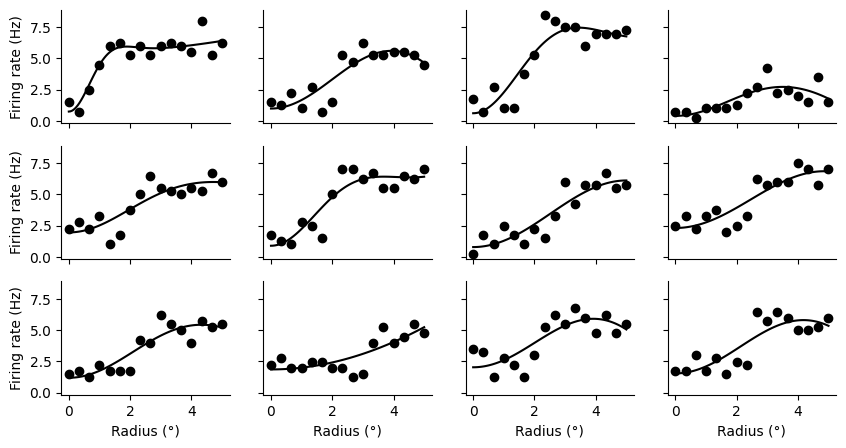

In [20]:
# First 12 cells
fig, axs = plt.subplots(3, 4, figsize=(10, 5), sharex=True, sharey=True)

for idx_cell, cell in enumerate(cells):

    if idx_cell > 11:
        break

    values = [cell.get_mean_rate_for_radius(radius) for radius in radiuses]
    rads = list(radiuses)

    rads, values = zip(*sorted(zip(rads,values)))
    rads = numpy.array(rads)
    values = numpy.array(values)

    res = differential_evolution(
        error_function_evo,
        bounds=[(0, 60), (0, 20), (0, 60), (0, 15), (0, 15), (0, 25), (0, 5)],
        args=(rads, values),
        strategy='rand2bin',
        maxiter=10000,
        popsize=30,
        tol=0.1,
        mutation=(0.5, 1.5),
        recombination=0.95,
        workers=1,
    )

    X_fit = numpy.linspace(0, 5, 100)
    Y_fit = sum_of_gaussian(res.x, X_fit)

    ax = axs[idx_cell % 3, idx_cell // 3]
    ax.scatter(rads, values, color="black")
    ax.plot(X_fit, Y_fit, color="black")

for ax in axs.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
for col in range(3):
    axs[col, 0].set_ylabel("Firing rate (Hz)")
for row in range(4):
    axs[-1, row].set_xlabel("Radius (°)")

plt.savefig(f"./figures/fit_size_tuning_{run_id}.png", dpi=100, bbox_inches="tight", transparent=True)
plt.show()

0 0 1357


/tmp/ipykernel_1213434/3860347402.py:7: RuntimeWarning: divide by zero encountered in divide
  return (p[0] * erf(x / p[1])**2
/tmp/ipykernel_1213434/3860347402.py:7: RuntimeWarning: invalid value encountered in divide
  return (p[0] * erf(x / p[1])**2
/tmp/ipykernel_1213434/3860347402.py:8: RuntimeWarning: divide by zero encountered in divide
  - p[2] * erf(x / (p[1] + p[3]))**2
/tmp/ipykernel_1213434/3860347402.py:8: RuntimeWarning: invalid value encountered in divide
  - p[2] * erf(x / (p[1] + p[3]))**2


100 3 1357


/tmp/ipykernel_1213434/3860347402.py:9: RuntimeWarning: divide by zero encountered in divide
  + p[4] * erf(x / (p[1] + p[3] + p[5]))**2
/tmp/ipykernel_1213434/3860347402.py:9: RuntimeWarning: invalid value encountered in divide
  + p[4] * erf(x / (p[1] + p[3] + p[5]))**2


200 10 1357


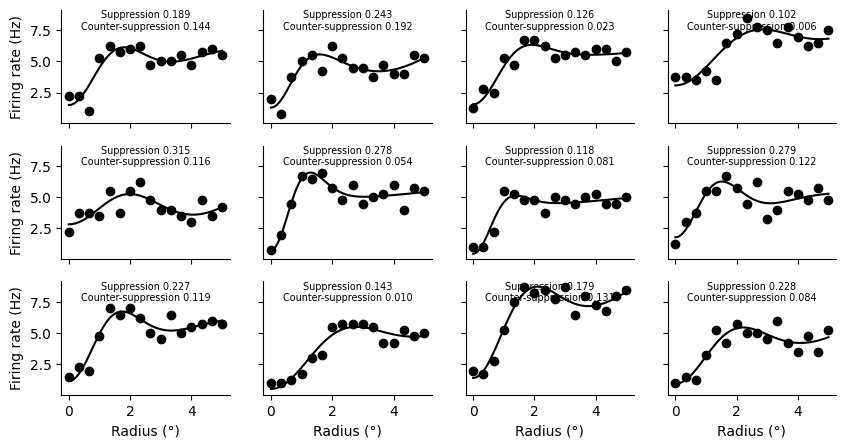

In [21]:
# 12 cherry picked cells
fig, axs = plt.subplots(3, 4, figsize=(10, 5), sharex=True, sharey=True)

current_idx = 0
for idx_cell, cell in enumerate(cells):

    if idx_cell % 100 == 0:
        print(idx_cell, current_idx, len(cells))

    values = [cell.get_mean_rate_for_radius(radius) for radius in radiuses]
    rads = list(radiuses)

    rads, values = zip(*sorted(zip(rads,values)))
    rads = numpy.array(rads)
    values = numpy.array(values)

    res = differential_evolution(
        error_function_evo,
        bounds=[(0, 60), (0, 20), (0, 60), (0, 15), (0, 15), (0, 25), (0, 5)],
        args=(rads, values),
        strategy='rand2bin',
        maxiter=10000,
        popsize=30,
        tol=0.1,
        mutation=(0.5, 1.5),
        recombination=0.95,
        workers=1,
    )

    X_fit = numpy.linspace(0, 5, 100)
    Y_fit = sum_of_gaussian(res.x, X_fit)

    error = error_function_evo(res.x, *(rads, values))
    
    max_response = numpy.max(Y_fit)
    crf_index  = numpy.argmax(Y_fit)
    crf_size = X_fit[crf_index]

    if crf_index < len(Y_fit)-1:
        supp_index = crf_index+numpy.argmin(Y_fit[crf_index+1:])+1
    else:
        supp_index = len(Y_fit)-1
    supp_size = X_fit[supp_index]

    if supp_index < len(Y_fit)-1:
        cs_index = supp_index+numpy.argmax(Y_fit[supp_index+1:])+1
    else:
        cs_index = len(Y_fit)-1

    if Y_fit[crf_index] != 0:
        si = (Y_fit[crf_index] - Y_fit[supp_index]) / Y_fit[crf_index]
    else:
        si = 0

    if Y_fit[cs_index] != 0:
        csi = (Y_fit[cs_index] - Y_fit[supp_index]) / Y_fit[crf_index]
    else:
        csi = 0

    if si > 0.1 and csi > 0.:
        ax = axs[current_idx % 3, current_idx // 3]
        ax.scatter(rads, values, color="black")
        ax.plot(X_fit, Y_fit, color="black")
        ax.set_title(f"Suppression {si:.3f}\nCounter-suppression {csi:.3f}", y=1.0, pad=-14, size="x-small")
        current_idx += 1

        if current_idx > 11:
            break

for ax in axs.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
for col in range(3):
    axs[col, 0].set_ylabel("Firing rate (Hz)")
for row in range(4):
    axs[-1, row].set_xlabel("Radius (°)")

plt.savefig(f"./figures/fit_size_tuning_cherrypicked{run_id}.png", dpi=100, bbox_inches="tight", transparent=True)
plt.show()